This Colab document contains the contents of the lidar processing pdf, edited to resolve issues with undefined variables and to read in data from a shared Google Drive folder

In [ ]:
#additional cell that I added for mounting Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We have raw lidar data for the two fields 21atu2_vw 2021-08-18 and 21atue_vw 2021-08-18. In each folder is a csv titled with the name and date of the field. That csv has the unique id of the collection (which maps to the other folders in there), the timestamp when it was taken as well as the start and end uptime for the particular column and range.

For example, the first entry of csv 21atu2_vw_2021-08-18.csv is:

<img src = 'https://i.imgur.com/emm5BLk.png'>

Looking in the folder f1a89bc8-1166-4236-aced-cd1517ce55c0, you can see the system_log.csv and secondary_lidar_log.csv for that collection. The uptime is the second column of the system log so if we want the data from column 1 range 10, we just look at the rows that have uptimes greater than 435137 and less than 443212.
Likewise, the first column of the secondary lidar log is the uptimes so filtering for rows with uptimes greater than 435137 and less than 443212 gives the lidar data for column 1 range 10.

The remaining columns of secondary_lidar_log.csv are the raw lidar returns (distance the lidar traveled at the 1080 intervals of the 270 degree arc that was swept). To work with it, get the data into a numpy array however you want, e.g.:

In [ ]:
#notes from Thomas Aref video: plot splits are divided into times
#plot splits are already done, EarthSense is reasonably sure that the data is grouped accurately into plots
#so filtering on uptimes allows us to pick out different data

import numpy as np

secondary_log=np.genfromtxt("/content/drive/MyDrive/Group2Module2_CSS844/Robot_lidar/21atu2_vw_2021-08-18/f1a89bc8-1166-4236-aced-cd1517ce55c0/secondary_lidar_log.csv", delimiter=",")
#^Anne note: I changed the file path from what it was in the original pdf, so that it now works with our colab setup 
  #(changed it from "MichiganState/..." to "/content/drive/MyDrive/Group2Module2_CSS844/Robot_lidar/...")

The first column is the uptime so we want to extract just the lidar data and convert it to meters (divide by 1000):

In [ ]:
#notes from Thomas Aref video: the data comes as an integer in millimeters, so we divide by 1000 to convert to meters
data=secondary_log[:,1:]/1000

#below added by Anne to view the data in the array v
data[:10]

array([[0.204, 0.208, 0.208, ..., 0.234, 0.234, 0.238],
       [0.206, 0.208, 0.212, ..., 0.232, 0.23 , 0.232],
       [0.208, 0.21 , 0.212, ..., 0.236, 0.236, 0.239],
       ...,
       [0.208, 0.206, 0.208, ..., 0.23 , 0.235, 0.228],
       [0.203, 0.208, 0.212, ..., 0.236, 0.237, 0.235],
       [0.21 , 0.213, 0.211, ..., 0.235, 0.234, 0.238]])

The lidar goes up to about 65.5 meters as "infinite". If desired, we can remove such returns with a simple mask,though it's not required or used in what is below:

In [ ]:
data_mask = data < 65    
masked_data=data*data_mask

To convert the data to cartesian coordinates (height and distance to the side), apply sine and cosine as follows:

In [ ]:
#notes from Thomas Aref video: this is some trig to get horizontal and vertical distances of the point 
#ultimately we want to calculate (x,y,z) coordinates from angle distance information
#this cell gives 2 out of the 3 coordinates that go into point clouds
#we do not have to really do alignment, unlike what was discussed for the use cases in Daniel Morris's video

sample_size=data.shape[1]    
angles=(225-np.arange(sample_size)*270/sample_size)*np.pi/180    
cos=-np.cos(angles)    
sin=np.sin(angles)    
side=cos*data    
height=sin*data

#notes from Thomas Aref video: to get the third coordinate, we can then use:
  #odometry from robot (columns 40 + 41 of system log give wheel speeds, which can be added up to give distance travelled)
  #or (better option) GPS data 
#the GPS data below looks pretty good which is part of why GPS is a good option for this year's data
#though note problems below in left GPS map where robot seems to have gone backwards, this can ultimately cause problems with the data

These would be the x and z coordinates if y is pointing forward. The transformation is just building up sine and cosine terms based on the order of the columns (since the angle for every column is always the same) and then using numpy's array multiplication to efficiently apply the transformation to all elements. The z coordinate is the position/distance the robot has traveled. There are two ways to get this: from odometry of the robot or from GPS. Odometry has the drawback that it's just trying to figure out how far the robot has traveled based on the motion of the robot's wheels. If the wheels slip or the robot crashes into a plant, the data will be off. GPS generally looks to give a more accurate position/distance traveled of the robot but is sometimes not available or can have weak signal. The GPS map for the two fields is shown below and looks quite reliable. You can generate these GPS maps from columns 22 and 23 in the system_log.csv.

<img src= 'https://i.imgur.com/QMBvKoA.png'>


You can convert GPS latitude/longitude into meter distances with the haversine formula: https://en.wikipedia.org/wiki/Haversine_formulaTo apply the haversine formula, you need to pick an origin for measuring distances from. For a plot or collection, the latitude and longitude from the first row in the system_log is fine.

In [ ]:
#notes from Thomas Aref video: you can work with the longitude and latitude directly, but they are not in a unit that makes sense for distances
#so we convert GPS distance into meter distances 
#there are several ways to convert GPS distance into meter distances:
  #this code and the cells below use the Haversine formula and trigonometry of spheres to get meter distances
  #there are also libraries like geopy that implement this under the hood 

sl_temp=np.genfromtxt("/content/drive/MyDrive/Group2Module2_CSS844/Robot_lidar/21atu2_vw_2021-08-18/f1a89bc8-1166-4236-aced-cd1517ce55c0/system_log.csv", delimiter=",")    
#Anne's note: ^ changed file path from original pdf (from "MichiganState/..." to "/content/drive/MyDrive/Group2Module2_CSS844/Robot_lidar/...")

# skip the first row which is header    
sl_uptimes=sl_temp[1:,1]    
lats=sl_temp[1:,22]    
lons=sl_temp[1:,23]    
origin_lat=lats[0]    
origin_lon=lons[0]

It's convenient to define these numpy trigonemetric functions:

In [ ]:
def d_cos(angles):        
  """takes cosine of angle in degrees"""        
  return np.cos(np.radians(angles))

def d_sin(angles):        
  """sine of angle in degrees"""        
  return np.sin(np.radians(angles))

def d_hav(angles):        
  """haversine of theta in degrees: sin(theta/2)**2"""        
  return (1-d_cos(angles))/2

And take the Earth's radius (the earth's radius varies depending where you are but this is decent approximation):

In [ ]:
R = 6373.0*1000 # Earth Radius in meters

Then the distances are found by:

In [ ]:
relative_lats=lats-origin_lat    
relative_lons=lons-origin_lon    

a = d_hav(relative_lats) + d_cos(origin_lat)*d_cos(lats)*d_hav(relative_lons)    
distances = 2*R*np.arctan2(np.sqrt(a), np.sqrt(1-a))
sl_distances = 2*R*np.arctan2(np.sqrt(a), np.sqrt(1-a))

The system log and GPS updates at a different rate then the secondary lidar log so interpolation is needed:

In [ ]:
#notes from Thomas Aref video: this code relies on uptimes to combine data that updates at different time intervals
#the code takes system log distances (sl_distances) which are from GPS and system log uptimes
#then it makes interpolation function and extracts the distances from any uptimes that you feed into it
#this gives you the last coordinate needed for your point cloud

from scipy import interpolate 

#error (RESOLVED): "uptimes" is not defined
  #since the Aref video mentions "any uptimes that you feed into the interpolation function", I think we have to generate "uptimes" ourselves
  #I tried to create a list of uptimes with "uptimes = list(range(min_uptime, max_uptime))"
  #but then I get further errors when running "sides2=side[(uptimes>min_uptime) & (uptimes<max_uptime),:]" (a modified version of a line below)
  #(the error there is "'>' not supported between instances of 'list' and 'int'"")

min_uptime=435137    
max_uptime=443212    

#error (RESOLVED): 
#"sl_distances" below is not defined
  #the video states that "sl_distances" should be the system log distances
  #is this the same as what was defined above as "distances"? ["distances = 2*R*np.arctan2(np.sqrt(a), np.sqrt(1-a))"]
  #"distances" did ultimately use data from system_log.csv
  #but the interpolation function also references "distances" so I'm confused
#^Harry: Yeah "sl_distances" and "distances" are the same. I'm guessing it's an accident on his part

secondary_uptimes = secondary_log[:, 0]

uptime_distance_interp=interpolate.interp1d(sl_uptimes, sl_distances, bounds_error=False, fill_value=(distances[0], distances[-1])) 

#^Harry Note: This function is supposed to be used to interpolate the distance from the uptime in the secondary log
# This is because there are some differences in how the times update between files 
distances=uptime_distance_interp(secondary_uptimes) 

# The approximation seems good
print(distances[-5:])
print(sl_distances[-5:])

[55.04107751 55.04282376 55.04338256 55.04338256 55.04338256]
[55.01529926 55.0293427  55.0293427  55.04338256 55.04338256]


We want to look at just one plot so use the plot split interval to filter the data:

In [ ]:
   
sides2=side[(secondary_uptimes>min_uptime) & (secondary_uptimes<max_uptime),:] 
#error (RESOLVED): the variable "sides" isn't defined (should this be "side" as defined above?)
#^Harry: Yeah it looks like it should be side. Also the uptime comes from the secondary_log file
distances2=distances[(secondary_uptimes>min_uptime) & (secondary_uptimes<max_uptime)]  
heights2=height[(secondary_uptimes>min_uptime) & (secondary_uptimes<max_uptime),:] 

Now you have the coordinates for the point cloud and can visualize the data. For example to see the raw lidar returns of the left side, you can run this:

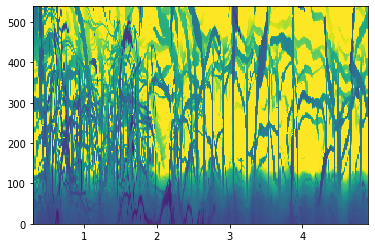

In [ ]:
import matplotlib.pyplot as plt
plt.figure()   
plt.pcolormesh(distances2,np.arange(sides2[:,:540].shape[1]), np.abs(data.T[:540, (secondary_uptimes>min_uptime) & (secondary_uptimes<max_uptime)]), vmin=0, vmax=1, shading='flat')   
plt.show()

And to see just the horizontal distance, you can run this:

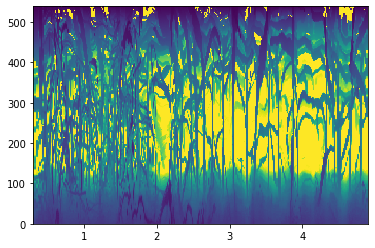

(322,)


In [ ]:
plt.pcolormesh(distances2,np.arange(sides2[:,:540].shape[1]), np.abs(sides2.T[:540, :]), vmin=0, vmax=1, shading="auto")    
plt.show()

#notes from Thomas Aref video: plots below show one side (left side he thinks)
#reason why two plots are different below: ground is close at bottom, then intermediate distance to plants
  #then as you get into the top of the canopy your horizontal distances come in close again at the top

The raw lidar shows the stems of the corn plants until it fades out at the top as the it sweeps into the air gap between the plants. The horizontal distances also shows thestems and leaves and closes at the top as the canopy closes.

<img src = 'https://i.imgur.com/Wez5c5u.png'>





You can also generate the point cloud since you have all three dimensions, though you need to extend the dimension of the distances (it's roughly the same for all the points in one scan)

In [ ]:
distances3= np.tile(distances2, (1081,1)).T    
length=distances2.shape[0]
xyz = np.zeros((length, sample_size, 3))    
xyz[:, :, 0] = sides2      # horizontal    
xyz[:, :, 1] = distances3  # forward  
xyz[:, :, 2] = heights2    # vertical

xyz

#notes from Thomas Aref video: 
#at this point you can feed the generated point cloud into whatever point cloud visualization software you want and do further algorithms of interest
#they are interested in per plant level 
#Addie's explanation of possible future directions:
  #we can use a point cloud from raw lidar data to try and model and predict traits measured on the ground by hand
    #(think about different ways to do feature extraction or other types of predictive modelling)
  #we can also create visualizations or even data exploration tools for WeaverPopcorn to explore how useful the robot is
    #(visualizations about how well EarthSense outputs match what was actually measured)

#other video notes:
#lai = leaf area index
#the number of detections for traits usually hovers around a fixed value 
  #exceptions indicate points to flag and exclude when doing further analysis 
  #exceptions might represent some issue like a plot being cut off in a strange way, or it might be that the camera was blurry so stems were hard to detect
#left and right heights are often correlated

#plans for the future:
#3d point cloud can be converted to 2d density map(as in Gage plant phenome paper which ultimately used low-dimension data to make predictions. read this paper for next class). might not even need to bother with getting data in 2d if we do pca
#can pass through model (like autoencoders - an unsupervised learning model, meaning we don't need to label data but just want to reconstruct data that we have)
#(in paper Conv2D) to get compressed/encoded representation of image
#then create another small model (ex. partial least squares regression or other regression) that takes encoded data (set of features for each image) and tries to predict traits
#goal is to predict ground truth traits (in *_ground_traits.xlsx files. maybe we will choose one trait to predict. yield?)
#two focuses to move towards:
  #1. convolutional neural network (convolutional autoencoder)
  #2. the data that we have
  #output is predict phenotype






(322, 1081, 3)


In [ ]:
# Save as numpy file
with open("plot.npy", "wb") as f:
    np.save(f, xyz)